# Examples of the BioSCRAPE package
## Biocircuit Stochastic Simulation of Single Cell Reactions and Parameter Estimation
The purpose of this Python notebook is twofold.

1. The first is to serve as a quick start guide where you should be able to get started with the package by simply looking at the examples here and copying them to your liking.

2. The second is as a unit testing replacement. It is hard to unit test stochastic algorithms as the output may not (and should not) be the same thing every time. Therefore, instead, if all the examples included below work well, then you can assume that the package installed correctly and is working fine.

Before, getting started, we start by doing some basic plotting configuration and importing the numpy library. Advanced users can modify this to their liking.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
#%config InlineBackend.figure_f.ormats=['svg']
color_list = ['r', 'k', 'b','g','y','m','c']
mpl.rc('axes', prop_cycle=(mpl.cycler('color', color_list) ))
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12)
import numpy as np

# Bioscrape Models
## Chemical Reactions
Bioscrape models consist of a set of species and a set of reactions (delays will be discussed later). These models can be simulated either stochastically via SSA or deterministically as an ODE. Each reaction is of the form

$\{INPUTS\} \xrightarrow[]{\rho(.)} \{OUTPUTS\}$

Here, INPUTS represent a multiset of input species and OUTPUTS represents a multiset of output species. The function $\rho(.)$ is either a deterministic rate function or a stochastic propensity. Propensities are identified by their name and require parameter dictionary with the appropriate parameters. The following functions are supported:

1. "massaction: $\rho(S) = k \Pi_{s} s^{I_s}$. Required parameters: "k" the rate constant. Note: for stochastic simulations mass action propensities are $\rho(S) = \frac{1}{V} k \Pi_{s} s!/(s - I_s)!$ where $V$ is the volume.
2. "positivehill": $\rho(s) = k \frac{s^n}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s".
3. "negativehill": $\rho(s) = k \frac{1}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s".
4. "proportionalpositivehill": $\rho(s) = k d \frac{s^n}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s", propritional species "d".
5. "proportionalnegativehill": $\rho(s) = k d \frac{1}{(K^n+s^n)}$. Requried parameters: rate constant "k", offset "K", hill coefficient "n", hill species "s", propritional species "d".
6. "general": $\rho(s) = f(s)$ where $f$ can be any algebraic function typed as a string. Required parameters: "rate" an algebraic expression including species and model parameters written as a string.

More details on all these propensity types can be found in the <a href="https://github.com/ananswam/bioscrape/wiki/Propensities">wiki documentation</a> 

## Transcription Translation Example
First, the following model of transcription and translation will be created programatically. There are three chemical species: $G$ is a gene, $T$ is a transcript, $X$ is a protein.

1. $G \xrightarrow[]{\rho_{tx}(G, I)} G+T$; $\rho_{tx}(G, I) = G k_{tx}\frac{I^{n}}{K_{I}^{n}+I^{n}}$, $I$ is an inducer.
2. $T \xrightarrow[]{\rho_{tl}(T)} T+X$; $\rho_{tl}(T) = k_{tl} \frac{T}{K_{R} + T}$, $k_{tl}$ and $K_R$ model effects due to ribosome saturation.
3. $T \xrightarrow[]{\delta} \varnothing$; massaction kinetics at rate $\delta$.
4. $X \xrightarrow[]{\delta} \varnothing$; massaction kinetics at rate $\delta$.

The first reaction uses a proportional positive hill function as its rate function to represent induction. The second reaction uses a positive hill function function to represent ribosome saturation. The third and fourth reactions reaction represent degredation via dilution. No delays will be included in this model. This model is constructed below and simulated both stochastically and deterministically.

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The follow species are uninitialized and their value has defaulted to 0: T, X, 


Text(0.5,0,'Time')

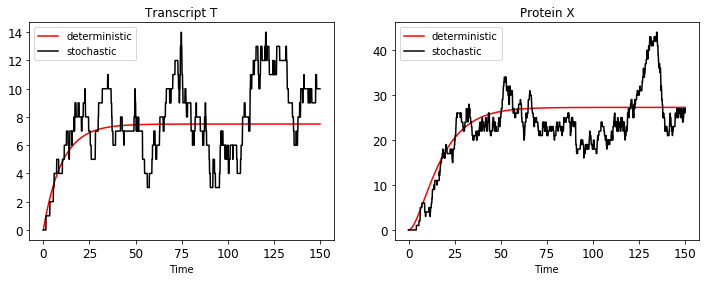

In [2]:
from bioscrape.simulator import py_simulate_model
from bioscrape.types import Model

#Create a list of species names (strings)
species = ["G", "T", "X", "I"]

#create a list of parameters in the form (param_name[string], param_val[number])
params = [("ktx", 1.5), ("ktl", 10.0), ("KI", 10), ("n", 2.0), ("KR", 20), ("delta", .1)]

#create reaction tuples in the form:
#(Inputs[string list], Outputs[string list], propensity_type[string], propensity_dict {propensity_param:model_param})
rxn1 = (["G"], ["G", "T"], "proportionalhillpositive", {"d":"G", "s1":"I", "k":"ktx", "K":"KI", "n":"n"})
rxn2 = (["T"], ["T", "X"], "hillpositive", {"s1":"T", "k":"ktl", "K":"KR", "n":1}) #Notice that parameters can also take numerical values instead of being named directly
rxn3 = (["T"], [], "massaction", {"k":"delta"})
rxn4 = (["X"], [], "massaction", {"k":"delta"})

#Create a list of all reactions
rxns = [rxn1, rxn2, rxn3, rxn4]

#create an initial condition dictionary species not included in the dictionary will default to 0
x0 = {"G":1, "I":10}

#Instaniate the Model object
M = Model(species = species, parameters = params, reactions = rxns, initial_condition_dict = x0)

#Simulate the Model deterministically
timepoints = np.arange(0, 150, .1)
results_det = py_simulate_model(timepoints, Model = M) #Returns a Pandas DataFrame

#Simulate the Model Stochastically
results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True)

#Plot the results
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title("Transcript T")
plt.plot(timepoints, results_det["T"], label = "deterministic")
plt.plot(timepoints, results_stoch["T"], label = "stochastic")
plt.legend()
plt.xlabel("Time")

plt.subplot(122)
plt.title("Protein X")
plt.plot(timepoints, results_det["X"], label = "deterministic")
plt.plot(timepoints, results_stoch["X"], label = "stochastic")
plt.legend()
plt.xlabel("Time")

## Adding Delays
In stochastic simulations, bioscrape also supports delay. In a delay reaction, delay inputs/outputs are consumed/produced after some amount of delay. Reactions may have a mix of delay and non-delay inputs and outputs. Bioscrape innately supports a number of delay-types:

1. fixed: constant delay with parameter "delay".
2. Gaussian: gaussian distributed delay with parameters "mean" and "std".
3. Gamma: gamma distributed delay with shape parameter "k" and scale parameter "theta".

In the following example model, the following delays are added to the transcription and translation reactions described above and then simulated stochastically. Note that delays and delay inputs/outputs will be ignored if a model with delays is simulated deterministically.

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The follow species are uninitialized and their value has defaulted to 0: T, X, 


Text(0.5,0,'Time')

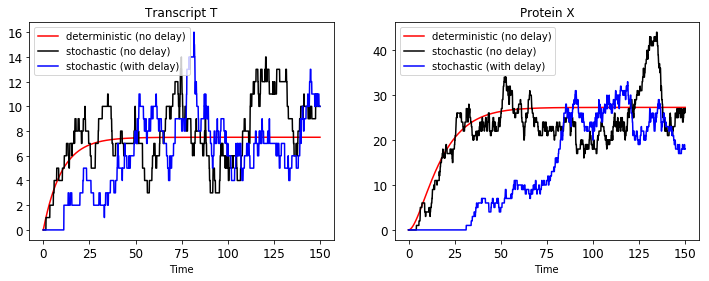

In [3]:
from bioscrape.simulator import py_simulate_model
from bioscrape.types import Model

#create reaction tuples with delays require additional elements. They are of the form:
#(Inputs[string list], Outputs[string list], propensity_type[string], propensity_dict {propensity_param:model_param},
# delay_type[string], DelayInputs [string list], DelayOutputs [string list], delay_param_dictionary {delay_param:model_param}).

rxn1d = (["G"], ["G"], "proportionalhillpositive", {"d":"G", "s1":"I", "k":"ktx", "K":"KI", "n":"n"},
       "gaussian", [], ["T"], {"mean":10.0, "std":1.0})
rxn2d = (["T"], ["T"], "hillpositive", {"s1":"T", "k":"ktl", "K":"KR", "n":1},
        "gamma", [], ["X"], {"k":10.0, "theta":3.0})

#Reactions 3 and 4 remain unchanged
rxns_delay = [rxn1d, rxn2d, rxn3, rxn4]

#Instaniate the Model object, species, params, and x0 remain unchanged from the previous example
M_delay = Model(species = species, parameters = params, reactions = rxns_delay, initial_condition_dict = x0)

#Simulate the Model with delay
results_delay = py_simulate_model(timepoints, Model = M_delay, stochastic = True, delay = True)

#Plot the results
plt.figure(figsize = (12, 4))
plt.subplot(121)
plt.title("Transcript T")
plt.plot(timepoints, results_det["T"], label = "deterministic (no delay)")
plt.plot(timepoints, results_stoch["T"], label = "stochastic (no delay)")
plt.plot(timepoints, results_delay["T"], label = "stochastic (with delay)")
plt.legend()
plt.xlabel("Time")

plt.subplot(122)
plt.title("Protein X")
plt.plot(timepoints, results_det["X"], label = "deterministic (no delay)")
plt.plot(timepoints, results_stoch["X"], label = "stochastic (no delay)")
plt.plot(timepoints, results_delay["X"], label = "stochastic (with delay)")

plt.legend()
plt.xlabel("Time")

## Adding Rules
In deterministic and stochastic simulations, bioscrape also supports rules which can be used to set species or parameter values during the simulation. Rules are updated every simulation timepoint - and therefore the model may be sensitive to how the timepoint spacing.

The following example two rules will be added to the above model (without delay).

1. $I = I_0 H(T)$ where $H$ is the step function. Represents the addition of the inducer I at concentrion $I_0$ some time T. Prior to t=T, I is not present.
2. $S = M \frac{X}{1+aX}$ represents a saturating signal detected from the species X via some sort of sensor.

Rules can also be used for quasi-steady-state or quasi-equilibrium approximations, computing parameters on during the simulation, and much more!

There are two main types of rules:
1. "additive": used for calculating the total of many species. Rule 'equation' must be in the form $s_0 = s_1 + s_2 ...$ where $s_i$ each represents a species string.
2. "assignment": a general rule type of with 'equation' form $v = f(s, p)$ where $v$ can be either a species or parameter which is assigned the value $f(s, p)$ where $s$ are all the species and $p$ are all the parameters in the model and $f$ is written as an string.

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: The follow species are uninitialized and their value has defaulted to 0: S, 
c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Uninitialized Model Passed into ModelCSimInterface. Model.initialize() called automatically.


Text(0.5,0,'Time')

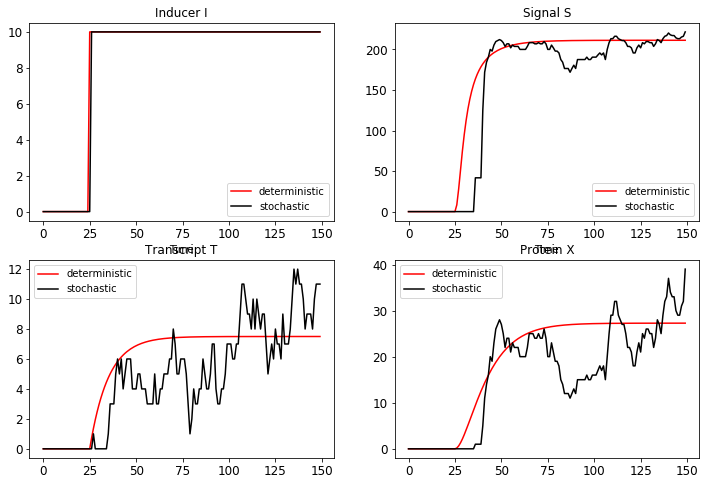

In [4]:
#Create new parameters for rule 1. Model is now being modified
M.create_parameter("I0", 10) #Inducer concentration
M.create_parameter("T", 25) #Initial time inducer is added

#Create rule 1:
#NOTE Rules can also be passed into the Model constructor as a list of tuples [("rule_type", {"equation":"eq string"})]
M.create_rule("assignment", {"equation":"I = _I0*Heaviside(t-_T)"}) #"_" must be placed before param names, but not species.

#Rule 2 will use constants in equations instead of new parameters. 
M.create_rule("assignment", {"equation":"S = 50*X/(1+.2*X)"}) #Species S is added automatically

#reset the initial concentration of the inducer to 0
M.set_species({"I":0})

#Simulate the Model deterministically
timepoints = np.arange(0, 150, 1.0)
results_det = py_simulate_model(timepoints, Model = M) #Returns a Pandas DataFrame

#Simulate the Model Stochastically
results_stoch = py_simulate_model(timepoints, Model = M, stochastic = True)

#Plot the results
plt.figure(figsize = (12, 8))
plt.subplot(223)
plt.title("Transcript T")
plt.plot(timepoints, results_det["T"], label = "deterministic")
plt.plot(timepoints, results_stoch["T"], label = "stochastic")
plt.legend()

plt.subplot(224)
plt.title("Protein X")
plt.plot(timepoints, results_det["X"], label = "deterministic")
plt.plot(timepoints, results_stoch["X"], label = "stochastic")
plt.legend()

plt.subplot(221)
plt.title("Inducer I")
plt.plot(timepoints, results_det["I"], label = "deterministic")
plt.plot(timepoints, results_stoch["I"], label = "stochastic")
plt.legend()
plt.xlabel("Time")

plt.subplot(222)
plt.title("Signal S")
plt.plot(timepoints, results_det["S"], label = "deterministic")
plt.plot(timepoints, results_stoch["S"], label = "stochastic")
plt.legend()
plt.xlabel("Time")


## Saving and Loading Bioscrape Models via Bioscrape XML

Models can be saved and loaded as Bioscrape XML. Here we will save and load the transcription translation model and display the bioscrape XML underneath. Once a model has been loaded, it can be accessed and modified via the API.

Bioscrape Model XML:
 <model>
<species name="G" value="1.0" />
<species name="T" value="0.0" />
<species name="X" value="0.0" />
<species name="I" value="0.0" />
<species name="S" value="0.0" />

<parameter name="KI" value="10.0" />
<parameter name="n" value="2.0" />
<parameter name="ktx" value="1.5" />
<parameter name="DummyVar_PositiveHillPropensity_n_0" value="1.0" />
<parameter name="KR" value="20.0" />
<parameter name="ktl" value="10.0" />
<parameter name="delta" value="0.1" />
<parameter name="I0" value="10.0" />
<parameter name="T" value="25.0" />

<reaction text= "G -- G + T ">
	<propensity type="proportionalhillpositive" d="G" s1="I" k="ktx" K="KI" n="n" />
	<delay type="none" />
</reaction>
<reaction text= "T -- T + X ">
	<propensity type="hillpositive" s1="T" k="ktl" K="KR" n="DummyVar_PositiveHillPropensity_n_0" />
	<delay type="none" />
</reaction>
<reaction text= "T -- ">
	<propensity type="massaction" k="delta" species="T" />
	<delay type="none" />
</reaction>
<reaction 

Text(0.5,0,'Time')

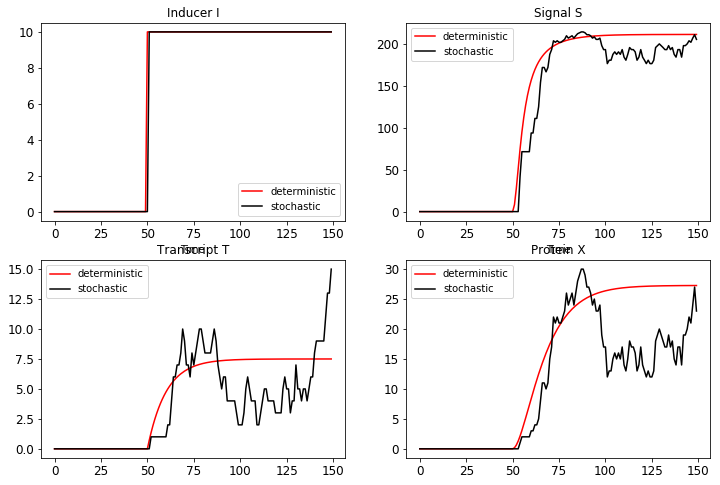

In [5]:
M.write_bioscrape_xml('models/txtl_model.xml')
f = open('models/txtl_model.xml')
print("Bioscrape Model XML:\n", f.read())

M_loaded = Model('models/txtl_model.xml')

#Change the induction time
#NOTE That changing a model loaded from xml will not change the underlying XML.
M_loaded.set_parameter("T", 50)

#Simulate the Model deterministically
timepoints = np.arange(0, 150, 1.0)
results_det = py_simulate_model(timepoints, Model = M_loaded) #Returns a Pandas DataFrame

#Simulate the Model Stochastically
results_stoch = py_simulate_model(timepoints, Model = M_loaded, stochastic = True)

#Plot the results
plt.figure(figsize = (12, 8))
plt.subplot(223)
plt.title("Transcript T")
plt.plot(timepoints, results_det["T"], label = "deterministic")
plt.plot(timepoints, results_stoch["T"], label = "stochastic")
plt.legend()

plt.subplot(224)
plt.title("Protein X")
plt.plot(timepoints, results_det["X"], label = "deterministic")
plt.plot(timepoints, results_stoch["X"], label = "stochastic")
plt.legend()

plt.subplot(221)
plt.title("Inducer I")
plt.plot(timepoints, results_det["I"], label = "deterministic")
plt.plot(timepoints, results_stoch["I"], label = "stochastic")
plt.legend()
plt.xlabel("Time")

plt.subplot(222)
plt.title("Signal S")
plt.plot(timepoints, results_det["S"], label = "deterministic")
plt.plot(timepoints, results_stoch["S"], label = "stochastic")
plt.legend()
plt.xlabel("Time")

# SBML Compatibility

The next cell imports a model from an SBML file and then simulates it using a deterministic simulation. There are limitations to SBML compatibility.

1. Cannot support delays or events when reading in SBML files. Events will be ignored and a warning will be printed out.
2. SBML reaction rates must be in a format such that when the reaction rates are converted to a string formula, sympy must be able to parse the formula. This will work fine for usual PEMDAS rates. This will fail for complex function definitions and things like that.
3. Species will be initialized to their initialAmount field when it is nonzero. If the initialAmount is zero, then the initialConcentration will be used instead.
4. Multiple compartments or anything related to having compartments will not be supported. No warnings will be provided for this.
5. Assignment rules are supported, but any other type of rule will be ignored and an associated warning will be printed out.
6. Parameter names must start with a letter and be alphanumeric, same for species names. Furthermore, log, exp, abs, heaviside, and other associated keywords for functions are not allowed to be variable names. When in doubt, just pick something else :)

Below, we first plot out the simulation results for an SBML model where a species X0 goes to a final species X1 through an enymatic process.

c:\users\apand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Warning: SBML model contains reversible reaction!
Please check rate expressions and ensure they are non-negative before doing stochastic simulations. This warning will always appear if you are using SBML 1 or 2
  


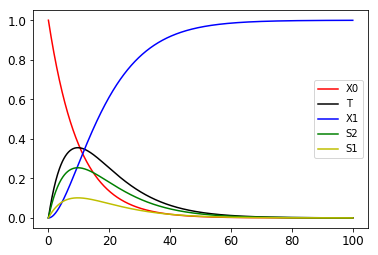

In [6]:
from bioscrape.types import read_model_from_sbml
M_sbml = read_model_from_sbml('models/sbml_test.xml')
timepoints = np.linspace(0,100,1000)

result = py_simulate_model(timepoints, Model = M_sbml)

plt.figure()
for s in M_sbml.get_species_list():
    plt.plot(timepoints, result[s], label = s)

plt.legend()

## Deterministic and Stochastic Simulation of the Repressilator

We  plot out the repressilator model found <a href="http://www.ebi.ac.uk/biomodels-main/BIOMD0000000012">here</a>. This model generates oscillations as expected. Highlighting the utility of this package, we then with a single line of code switch to a stochastic simulation and note that the amplitudes of each burst become noisy.

<Figure size 432x288 with 0 Axes>

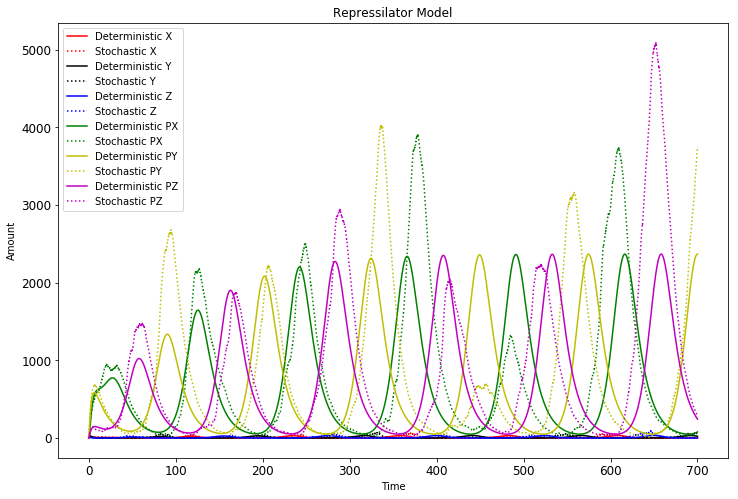

In [7]:
# Repressilator deterministic example
import bioscrape
plt.figure()
M_represillator = bioscrape.types.read_model_from_sbml('models/repressilator_sbml.xml')

#Simulate Deterministically and Stochastically
timepoints = np.linspace(0,700,10000)
result_det = py_simulate_model(timepoints, Model = M_represillator)
result_stoch = py_simulate_model(timepoints, Model = M_represillator, stochastic = True)

#Plot Results
plt.figure(figsize = (12, 8))
for i in range(len(M_represillator.get_species_list())):
    s = M_represillator.get_species_list()[i]
    plt.plot(timepoints, result_det[s], color = color_list[i], label = "Deterministic "+s)
    plt.plot(timepoints, result_stoch[s], ":", color = color_list[i], label = "Stochastic "+s)

plt.title('Repressilator Model')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend()

## Simulating Cell Lineages
See Lineage Examples for details on how to simulate single cells and lineages of cells.